In [23]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
data_raw = pd.read_csv("FBRef2020-21.csv")

In [3]:
data_proc = (data_raw.query("Min >= 500")
             .drop(columns = [column for column in data_raw.columns if data_raw[column].isna().sum() > 100]))

display(data_proc[data_proc.isna().sum(axis=1) != 0])

display(data_proc.loc[313].isna().sum())
display(data_proc.loc[1190].isna().sum())
display(data_proc.loc[2525].isna().sum())
display(data_proc.loc[2525].isna().sort_values())


data_proc = data_proc.drop(index=[313,1190,2525]).reset_index()

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
313,Salvador Ferrer,es ESP,DF,Spezia,it Serie A,22.0,1998.0,18,14,1190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1190,Jota,pt POR,FW,Valladolid,es La Liga,21.0,1999.0,17,7,668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2525,Martín Zubimendi,es ESP,MF,Real Sociedad,es La Liga,21.0,1999.0,31,17,1882,...,131.4,4.74,1.44,0.05,0.33,0.72,43.9,42.5,96.8,0.86


95

95

2

Player                 False
Att 3rdPress/90        False
Mid 3rdPress/90        False
Def 3rdPress/90        False
SuccPress/90           False
                       ...  
MedAtt/90              False
FKPassAtt/90           False
ProgPassReceived/90    False
ErrToShot/90            True
Clearances/90           True
Name: 2525, Length: 119, dtype: bool

In [4]:
data_num = data_proc.drop(columns = [col for col in data_proc.columns if data_proc[col].dtype not in ['float64','int64']])
data_num = data_num.drop(columns = data_num.columns.tolist()[:data_num.columns.tolist().index('Ast/90')])


## Clustering

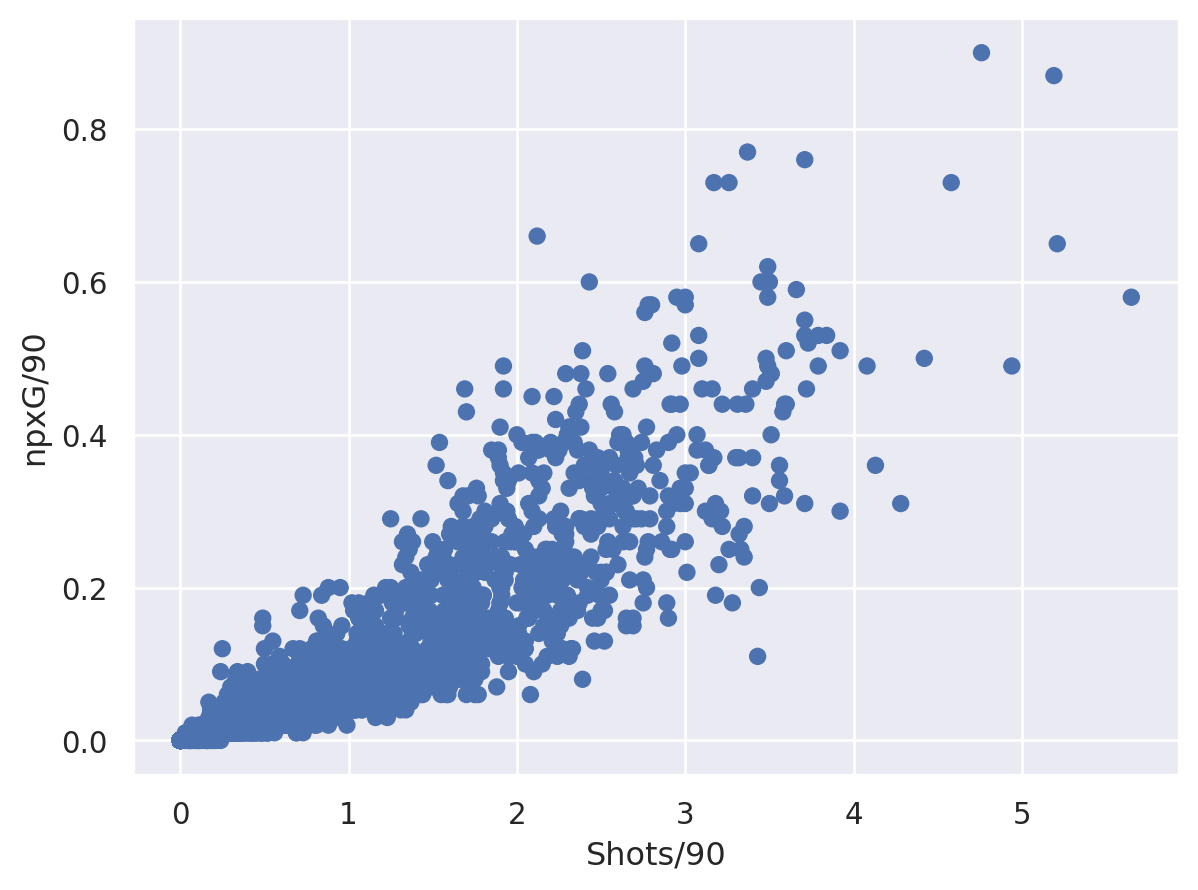

In [38]:
data_procesada = data_num.drop(columns=[col for col in data_num.columns if col not in ["Shots/90","npxG/90"]])
(
    so.Plot(data= data_procesada, x= "Shots/90", y= "npxG/90")
    .add(so.Dot())
)

In [27]:
X_star = StandardScaler().set_output(transform="pandas").fit_transform(data_num)

X_star_t = np.transpose(X_star)
N = len(X_star)
Sigma = (X_star_t @ X_star) / N

In [31]:
gamma, U = np.linalg.eigh(Sigma)

gamma_flip = np.flip(gamma)
U = np.flip(U, 1)
display(gamma_flip)

array([2.83548495e+01, 2.31482414e+01, 8.75805473e+00, 6.15050818e+00,
       3.38395968e+00, 2.98121630e+00, 2.33805761e+00, 1.85956741e+00,
       1.54042037e+00, 1.43743872e+00, 1.34121469e+00, 1.24763042e+00,
       1.18130292e+00, 1.08809404e+00, 9.87191708e-01, 9.05443792e-01,
       8.84525197e-01, 8.57245435e-01, 8.17578346e-01, 7.49063352e-01,
       7.02326888e-01, 6.64004607e-01, 6.27670271e-01, 6.01913328e-01,
       5.61094440e-01, 5.26055496e-01, 4.98750254e-01, 4.90334769e-01,
       4.80739457e-01, 4.55964370e-01, 4.28969639e-01, 4.08993626e-01,
       3.77182254e-01, 3.55064460e-01, 3.48007361e-01, 3.23806082e-01,
       3.12403741e-01, 3.11497765e-01, 3.06164931e-01, 2.92256492e-01,
       2.54868745e-01, 2.52268890e-01, 2.28670627e-01, 2.14380834e-01,
       2.00750949e-01, 1.97197554e-01, 1.89022332e-01, 1.78954974e-01,
       1.64938372e-01, 1.51821384e-01, 1.47032796e-01, 1.33856623e-01,
       1.20862547e-01, 1.19129273e-01, 1.09526695e-01, 1.06898113e-01,
      

In [39]:
Z = X_star @ U 
Z.columns = ["Z" + str(i) for i in range(1,104)]

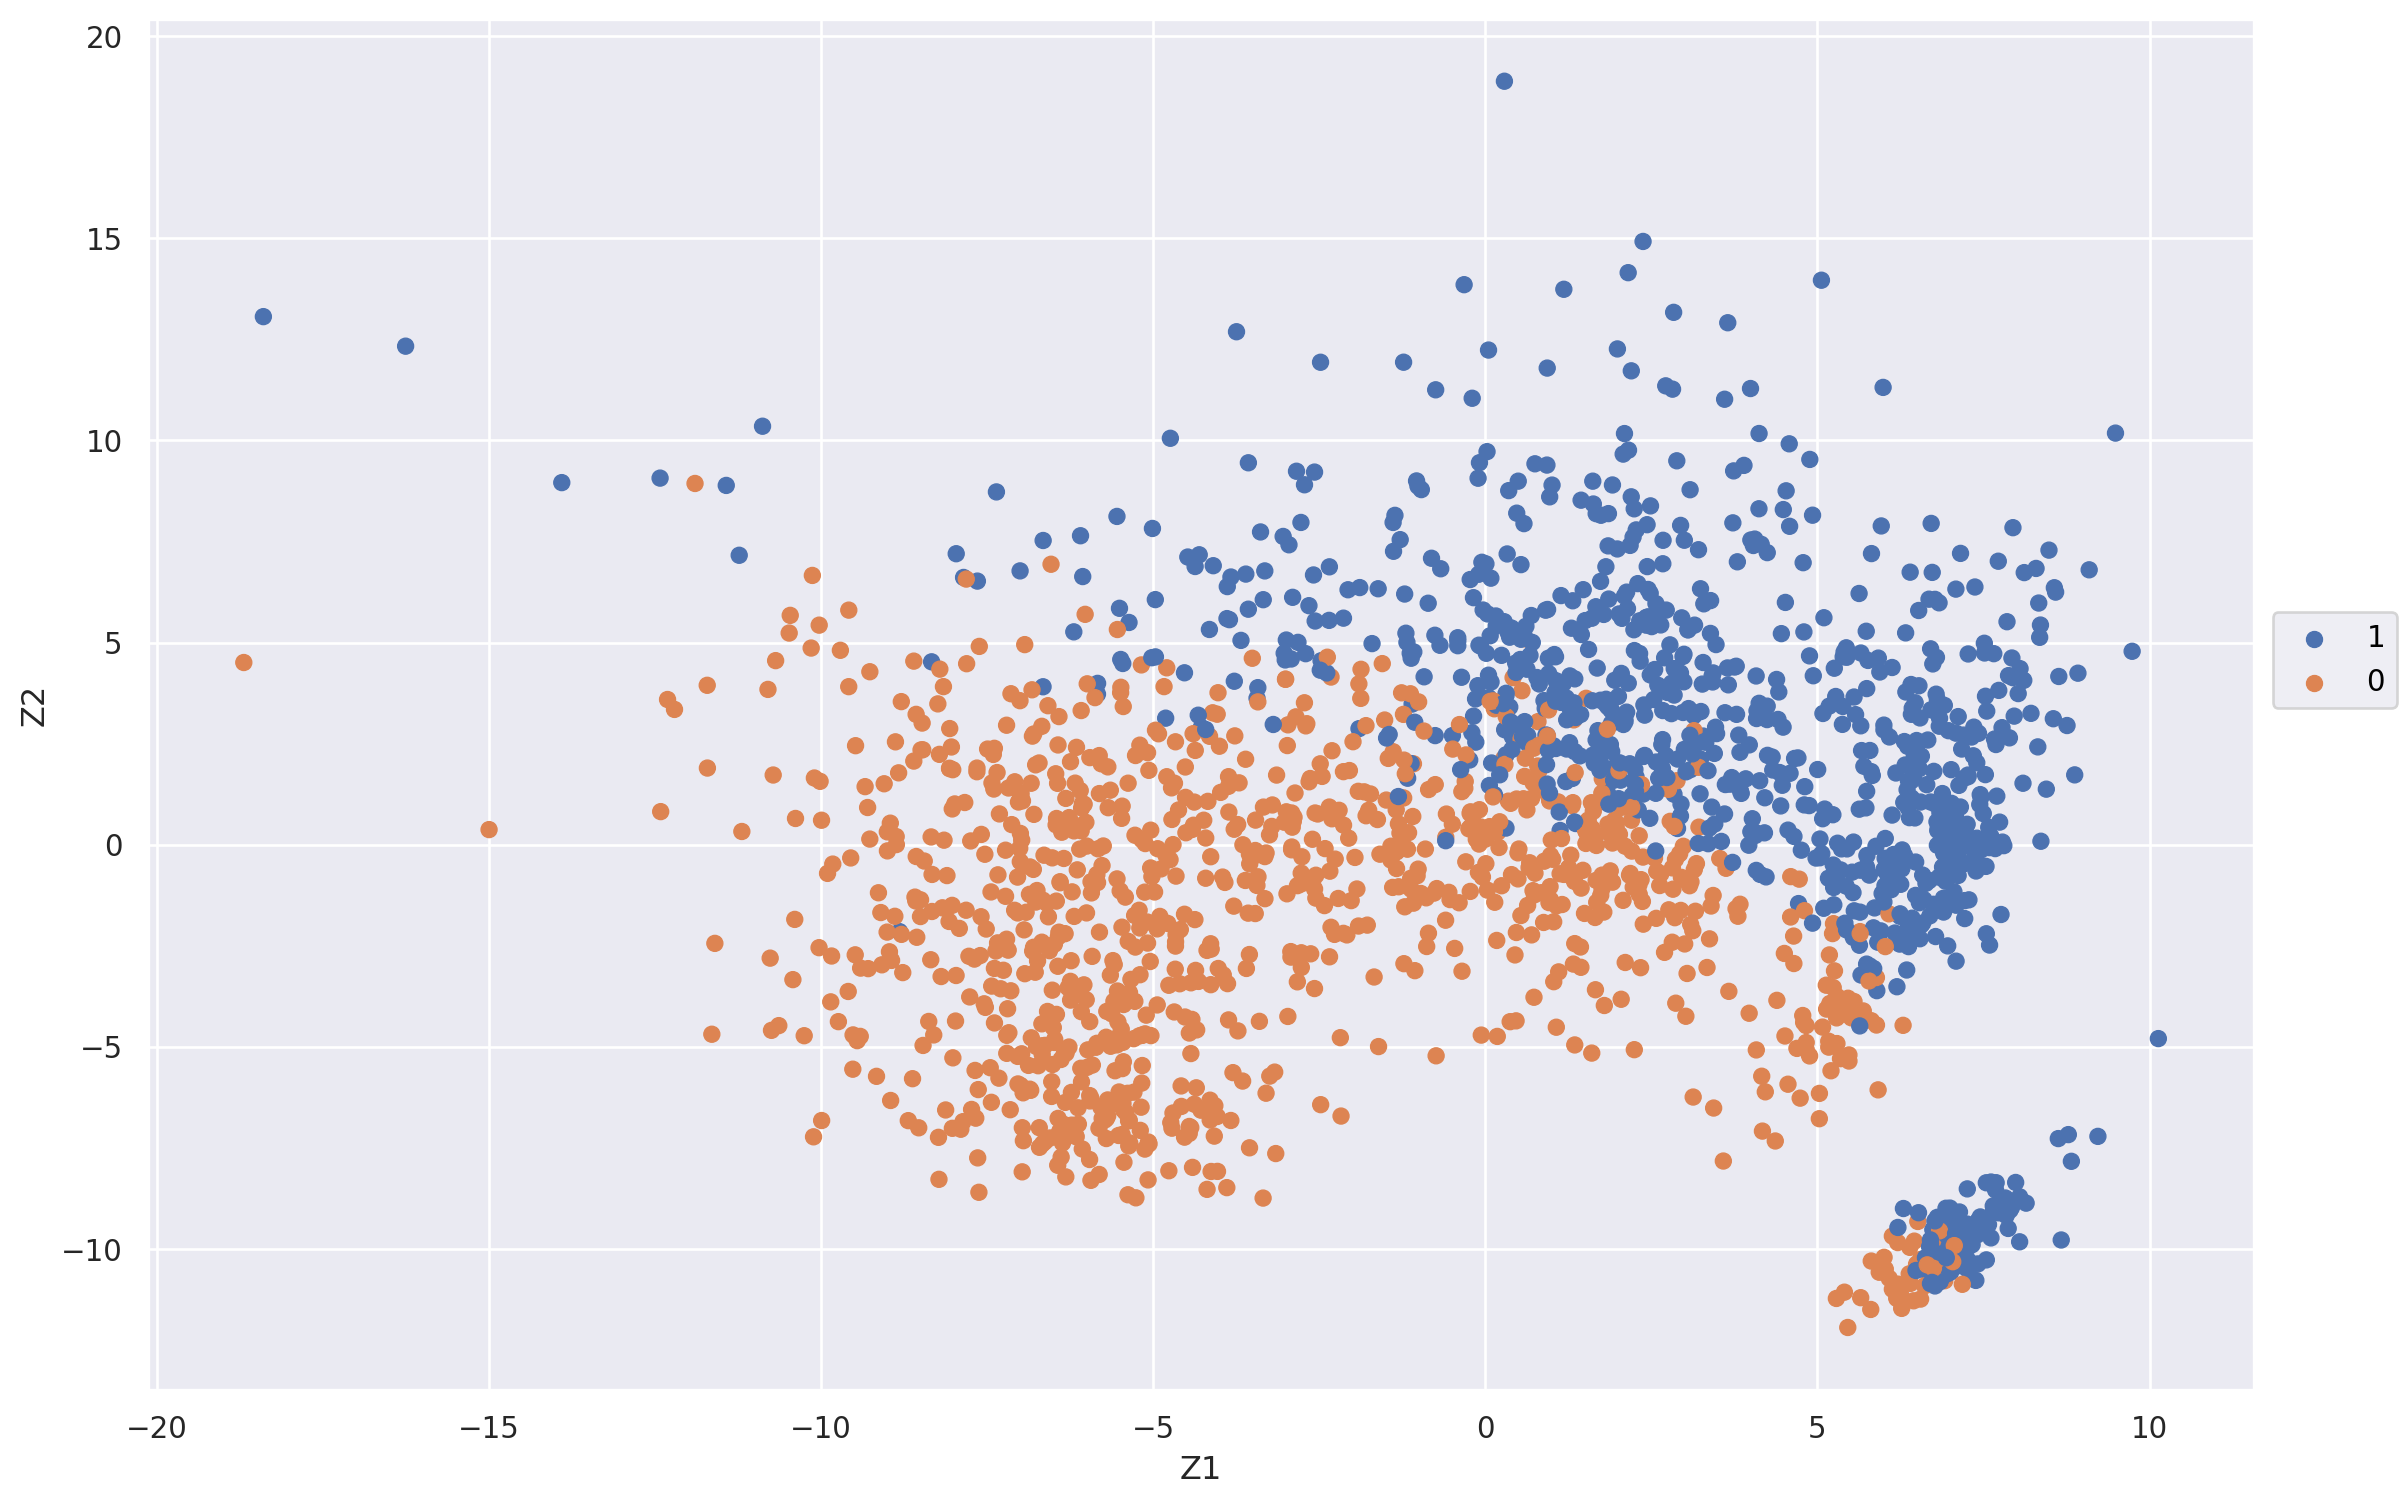

In [33]:
kmeans = KMeans (n_clusters = 2)

etiquetas = kmeans.fit_predict(data_num).astype(str)

(
    so.Plot()
    .add(so.Dot(), data = Z, x = "Z1", y = "Z2", color = etiquetas)
    .layout(size=(12,8))
)

## Clasificación

In [40]:
data_clasif = data_proc.drop(columns = [col for col in data_proc.columns if data_proc[col].dtype not in ['float64','int64']])
data_clasif = data_clasif.drop(columns = data_num.columns.tolist()[:data_num.columns.tolist().index('Ast/90')]).join(data_proc['Pos'].apply(lambda x: x.split(',')[0])).rename(columns = {'Pos': 'Pos_filt'})

X_train, X_test, y_train, y_test = train_test_split(data_num, data_clasif['Pos_filt'], test_size=0.2, random_state=42)

clsf = GridSearchCV(estimator = KNeighborsClassifier(),param_grid={'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}, cv = LeaveOneOut(), verbose=1)
clsf.fit(X_train,y_train)

Fitting 1567 folds for each of 19 candidates, totalling 29773 fits


GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20]},
             verbose=1)

In [15]:
model = KNeighborsClassifier(n_neighbors = 8)
model.fit(X_train,y_train)
score = model.score(X_test, y_test)
print(score)


0.8341836734693877


### Componentes principales

In [44]:
data_comp_princ = Z.drop(columns= Z.columns.tolist()[2:])

X_train, X_test, y_train, y_test = train_test_split(data_comp_princ, data_clasif['Pos_filt'], test_size=0.2, random_state=42)

clsf = GridSearchCV(estimator = KNeighborsClassifier(),param_grid={'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}, cv = LeaveOneOut(), verbose=1)
clsf.fit(X_train,y_train)


Fitting 1567 folds for each of 19 candidates, totalling 29773 fits


GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20]},
             verbose=1)

In [45]:
model = KNeighborsClassifier(n_neighbors = 14)
model.fit(X_train,y_train)
score = model.score(X_test, y_test)
print(score)

0.7448979591836735
